### Model_V0_Part 4: Exploratory Data Analysis on Variances itself
- The purpose of this one is trying to make transition from prediction on SET index to see the behavior in volatility itself.  
- The features include lagged variance (volatility clustering), squared shock and signed squared shock (asymmetric in shock).  
- The feature generation is very similar to model V1, so to make comparison about behavior of volatility in SET index.  
- What I have found is positive coeff of lagged variance (vol clustering), positive coeff of squared shock (shock -> inc in variance) and negative coeff of signed square shock (positive shock -> dec in variance because the negativity outweighs positivity of previous coeff).  
- The caveat is about the low R-square, but since I do not try to predict variance itself, I think it is fine for the sake of exploration.

In [1]:
import pandas as pd
import numpy as np

## Many scikit-learn packages to import
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
## First, we read the dataframe that we got from the last part (part 1)
## Remember the rule of ML: analyze only training set (do not touch validating or testing set if not specified so)
Train_df = pd.read_csv('SET_Train.csv')
Train_df['Date'] = pd.to_datetime(Train_df['Date'])
Validate_df = pd.read_csv('SET_Validate.csv')
Test_a_df = pd.read_csv('SET_Test_a.csv')
Test_b_df = pd.read_csv('SET_Test_b.csv')
Train_df.head()

,Date,Close,Volume,MA_diff_3,MA_diff_5,MA_diff_10,MA_diff_14,MA_diff_20,EMA_diff,MACD,...,STD_14,STD_20,Volume_Agent,Y_1,Y_3,Y_5,Y_10,Y_14,Y_20,Y_N_1
0,2008-01-02,842.97,1686634.0,0.590000,5.874,0.657,0.112857,1.1225,0.846747,-0.843428,...,19.004899,16.768455,1,-1,-1,-1,-1,-1,-1,1
1,2008-01-03,832.63,2203218.0,-6.476667,-2.130,1.501,-0.558571,-0.6085,-0.271927,-1.046243,...,18.795705,16.548025,1,-1,-1,-1,-1,-1,-1,1
2,2008-01-04,821.71,2244205.0,-12.130000,-3.898,0.781,-0.884286,-1.2365,-1.336735,-2.064332,...,18.863764,16.388750,1,-1,0,-1,-1,-1,-1,1
3,2008-01-07,808.31,1749336.0,-11.553333,-8.750,0.333,-1.770000,-1.1405,-2.543061,-3.907400,...,19.579607,17.186561,1,0,-1,-1,-1,-1,0,1
4,2008-01-08,811.69,1746730.0,-6.980000,-9.282,1.998,-1.765000,-1.0825,-1.950755,-5.037241,...,19.783006,17.660359,0,1,-1,-1,-1,-1,0,0


In [4]:
Train_df['Return_20'] = Train_df['Close'].pct_change(periods = 20)

In [7]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [18]:
Train_df['Return_3'] = Train_df['Close'].pct_change(periods = 3)
am_3 = arch_model(100*Train_df['Return_3'][3:] , p=1, o=1, q=1)
res_3 = am_3.fit(update_freq=5, disp='off')
res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:               Return_3   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4693.26
Distribution:                  Normal   AIC:                           9396.52
Method:            Maximum Likelihood   BIC:                           9425.51
                                        No. Observations:                 2438
Date:                Sun, Feb 14 2021   Df Residuals:                     2437
Time:                        08:11:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3107  4.204e-02      7.392  1.446e-13 [  0.228,  0.393]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2049  7.961e-02      2.574  1.004e-02 [4.891e-02,  0.361]
alpha[1]       0.3170  6.071e-02      5.222  1.772e-07   [  0.198,  0.436]
gamma[1]       0.2236  6.697e-02      3.338  8.429e-04 [9.231e-02,  0.355]
beta[1]        0.5712  8.253e-02      6.921  4.488e-12   [  0.409,  0.733]
==========================================================================

Covariance estimator: robust
"""

In [19]:
Train_df['Return_5'] = Train_df['Close'].pct_change(periods = 5)
am_5 = arch_model(100*Train_df['Return_5'][5:] , p=1, o=1, q=1)
res_5 = am_5.fit(update_freq=5, disp='off')
res_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:               Return_5   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -5175.53
Distribution:                  Normal   AIC:                           10361.1
Method:            Maximum Likelihood   BIC:                           10390.1
                                        No. Observations:                 2436
Date:                Sun, Feb 14 2021   Df Residuals:                     2435
Time:                        08:11:44   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4904  6.667e-02      7.357  1.885e-13 [  0.360,  0.621]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5072      0.117      4.353  1.341e-05   [  0.279,  0.736]
alpha[1]       0.5708  7.276e-02      7.846  4.299e-15   [  0.428,  0.713]
gamma[1]       0.1649  5.535e-02      2.980  2.885e-03 [5.644e-02,  0.273]
beta[1]        0.3467  6.330e-02      5.477  4.332e-08   [  0.223,  0.471]
==========================================================================

Covariance estimator: robust
"""

In [20]:
Train_df['Return_10'] = Train_df['Close'].pct_change(periods = 10)
am_10 = arch_model(100*Train_df['Return_10'][10:] , p=1, o=1, q=1)
res_10 = am_10.fit(update_freq=5, disp='off')
res_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:              Return_10   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -5758.51
Distribution:                  Normal   AIC:                           11527.0
Method:            Maximum Likelihood   BIC:                           11556.0
                                        No. Observations:                 2431
Date:                Sun, Feb 14 2021   Df Residuals:                     2430
Time:                        08:12:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.8712      0.126      6.925  4.354e-12 [  0.625,  1.118]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9928      0.178      5.566  2.606e-08    [  0.643,  1.342]
alpha[1]       0.7797  6.213e-02     12.549  4.007e-36    [  0.658,  0.901]
gamma[1]       0.0183  5.211e-02      0.352      0.725 [-8.380e-02,  0.120]
beta[1]        0.1877  6.244e-02      3.006  2.647e-03  [6.531e-02,  0.310]
===========================================================================

Covariance estimator: robust
"""

In [22]:
Train_df['Return_14'] = Train_df['Close'].pct_change(periods = 14)
am_14 = arch_model(100*Train_df['Return_14'][14:] , p=1, o=1, q=1)
res_14 = am_14.fit(update_freq=5, disp='off')
res_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:              Return_14   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6075.21
Distribution:                  Normal   AIC:                           12160.4
Method:            Maximum Likelihood   BIC:                           12189.4
                                        No. Observations:                 2427
Date:                Sun, Feb 14 2021   Df Residuals:                     2426
Time:                        08:13:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.1793      0.166      7.090  1.337e-12 [  0.853,  1.505]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1633      0.151      7.701  1.347e-14    [  0.867,  1.459]
alpha[1]       0.8429  4.951e-02     17.024  5.445e-65    [  0.746,  0.940]
gamma[1]       0.0558  4.385e-02      1.274      0.203 [-3.009e-02,  0.142]
beta[1]        0.1097  3.626e-02      3.024  2.492e-03  [3.859e-02,  0.181]
===========================================================================

Covariance estimator: robust
"""

In [23]:
Train_df['Return_20'] = Train_df['Close'].pct_change(periods = 20)
am_20 = arch_model(100*Train_df['Return_20'][20:] , p=1, o=1, q=1)
res_20 = am_20.fit(update_freq=5, disp='off')
res_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:              Return_20   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6452.80
Distribution:                  Normal   AIC:                           12915.6
Method:            Maximum Likelihood   BIC:                           12944.6
                                        No. Observations:                 2421
Date:                Sun, Feb 14 2021   Df Residuals:                     2420
Time:                        08:13:27   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.5259      0.206      7.390  1.468e-13 [  1.121,  1.931]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.2998      0.214      6.067  1.302e-09    [  0.880,  1.720]
alpha[1]       0.8622  4.840e-02     17.814  5.468e-71    [  0.767,  0.957]
gamma[1]       0.0276  3.726e-02      0.741      0.459 [-4.543e-02,  0.101]
beta[1]        0.1120  4.528e-02      2.474  1.337e-02  [2.327e-02,  0.201]
===========================================================================

Covariance estimator: robust
"""

In [26]:
res_20.params

mu          1.525864
omega       1.299804
alpha[1]    0.862207
gamma[1]    0.027590
beta[1]     0.112014
Name: params, dtype: float64

In [3]:
Train_df = Train_df[['STD_3', 'STD_5', 'STD_10', 'STD_14', 'STD_20', 'Close']]

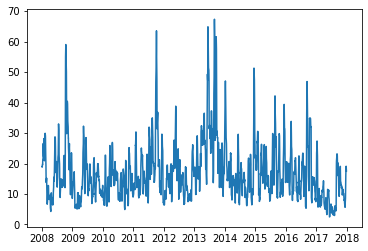

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_14'])

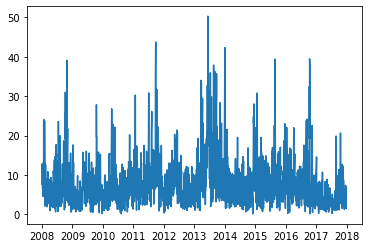

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_3'])

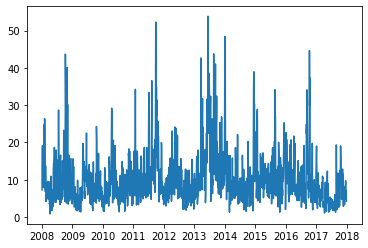

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_5'])

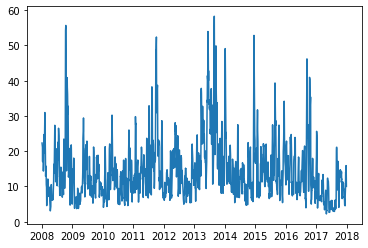

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_10'])

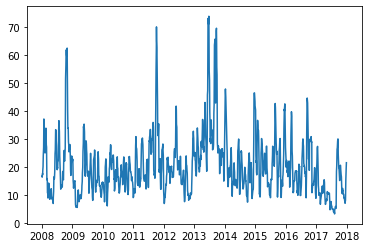

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_20'])

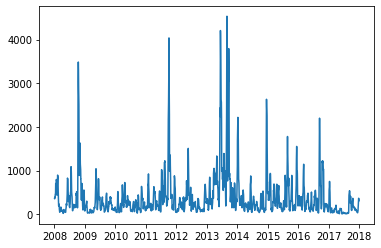

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Train_df['Date'], Train_df['STD_14']**2)

In [4]:
# Take the square to transform to variance
Train_df['STD_3'] = Train_df['STD_3'] **2
Train_df['STD_5'] = Train_df['STD_5'] **2
Train_df['STD_10'] = Train_df['STD_10'] **2
Train_df['STD_14'] = Train_df['STD_14'] **2
Train_df['STD_20'] = Train_df['STD_20'] **2

In [5]:
# Generate variables to predict: variance encompassing the data of next n days
Train_df['future_STD_3'] = Train_df['STD_3'].shift(-3)
Train_df['future_STD_5'] = Train_df['STD_5'].shift(-5)
Train_df['future_STD_10'] = Train_df['STD_10'].shift(-10)
Train_df['future_STD_14'] = Train_df['STD_14'].shift(-14)
Train_df['future_STD_20'] = Train_df['STD_20'].shift(-20)

In [6]:
# Generate error_squared and error_squared_signed variable for each forecast horizon

Err_3 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(3).mean().shift(1)
Err_3_dir = Err_3.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_3'] = Err_3 **2
Train_df['Error_signed_3'] = Train_df['Error_sq_3'] * Err_3_dir 

Err_5 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(5).mean().shift(1)
Err_5_dir = Err_5.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_5'] = Err_5 **2
Train_df['Error_signed_5'] = Train_df['Error_sq_5'] * Err_5_dir 

Err_10 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(10).mean().shift(1)
Err_10_dir = Err_10.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_10'] = Err_10 **2
Train_df['Error_signed_10'] = Train_df['Error_sq_10'] * Err_10_dir 

Err_14 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(14).mean().shift(1)
Err_14_dir = Err_14.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_14'] = Err_14 **2
Train_df['Error_signed_14'] = Train_df['Error_sq_14'] * Err_14_dir 

Err_20 = Train_df['Close'] -  Train_df.loc[:, 'Close'].rolling(20).mean().shift(1)
Err_20_dir = Err_20.apply(lambda x: 1 if x > 0 else 0)
Train_df['Error_sq_20'] = Err_20 **2
Train_df['Error_signed_20'] = Train_df['Error_sq_20'] * Err_20_dir 

In [7]:
Train_df = Train_df.iloc[20:-20, :]

In [47]:
Train_df.head()

,STD_3,STD_5,STD_10,STD_14,STD_20,Close,future_STD_3,future_STD_5,future_STD_10,future_STD_14,...,Error_sq_3,Error_signed_3,Error_sq_5,Error_signed_5,Error_sq_10,Error_signed_10,Error_sq_14,Error_signed_14,Error_sq_20,Error_signed_20
20,91.694433,197.58192,427.510650,483.758345,917.858736,763.48,242.762633,143.00727,167.647129,246.957735,...,110.180011,110.180011,318.408336,318.408336,19.210689,19.210689,24.885845,0.000000,455.267569,0.000000
21,227.784033,215.33427,380.670090,436.794407,771.143051,784.23,4.276133,80.48985,165.668089,189.952592,...,899.600044,899.600044,1157.904784,1157.904784,684.607225,684.607225,337.929437,337.929437,11.475156,11.475156
22,564.097300,697.17535,577.701773,543.920423,727.590295,810.86,78.663633,68.30833,190.986477,195.956987,...,1877.777778,1877.777778,2453.022784,2453.022784,2861.929009,2861.929009,2105.629880,2105.629880,1052.191406,1052.191406
23,242.762633,686.42335,850.998850,681.556092,738.528683,811.56,63.829033,46.44883,206.727929,226.010302,...,643.636900,643.636900,1600.000000,1600.000000,2712.118084,2712.118084,2041.167858,2041.167858,1134.342400,1134.342400
24,4.276133,448.61992,958.557188,790.389077,725.129901,807.68,52.950100,97.41178,247.588627,231.314875,...,29.848011,29.848011,514.382400,514.382400,1909.253025,1909.253025,1523.340900,1523.340900,878.381406,878.381406


In [ ]:
Validate_df = Validate_df[['STD_3', 'STD_5', 'STD_10', 'STD_14', 'STD_20', 'Close']]


In [11]:
import statsmodels.api as sm
X3 = Train_df[['STD_3', 'Error_sq_3', 'Error_signed_3']]
Y3 = Train_df['future_STD_3']
model3 = sm.OLS(Y3,sm.add_constant(X3))
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           future_STD_3   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     111.3
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           1.78e-67
Time:                        17:50:42   Log-Likelihood:                -15814.
No. Observations:                2401   AIC:                         3.164e+04
Df Residuals:                    2397   BIC:                         3.166e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             73.0657      4.113     17.763      0.000      65.000      81.132
STD_3              0.3561      0.040      8.897      0.000       0.278       0.435
Error_sq_3         0.0132      0.014      0.938      0.348      -0.014       0.041
Error_signed_3    -0.1085      0.014     -7.719      0.000      -0.136      -0.081
==============================================================================
Omnibus:                     2433.831   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153901.767
Skew:                           4.907   Prob(JB):                         0.00
Kurtosis:                      40.974   Cond. No.                         738.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
from sklearn.linear_model import LinearRegression
X3 = Train_df[['STD_3', 'Error_sq_3', 'Error_signed_3']]
Y3 = Train_df['future_STD_3']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.3560598   0.01316729 -0.10850597]
0.12227814683828664


In [55]:
X3 = Train_df[['STD_5', 'Error_sq_5', 'Error_signed_5']]
Y3 = Train_df['future_STD_5']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.2548224   0.0338041  -0.08503086]
0.1011792981799331


In [12]:
import statsmodels.api as sm
X5 = Train_df[['STD_5', 'Error_sq_5', 'Error_signed_5']]
Y5 = Train_df['future_STD_5']
model5 = sm.OLS(Y5,sm.add_constant(X5))
results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           future_STD_5   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     89.94
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           3.74e-55
Time:                        17:51:51   Log-Likelihood:                -16564.
No. Observations:                2401   AIC:                         3.314e+04
Df Residuals:                    2397   BIC:                         3.316e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            116.0399      5.882     19.727      0.000     104.505     127.575
STD_5              0.2548      0.035      7.238      0.000       0.186       0.324
Error_sq_5         0.0338      0.012      2.732      0.006       0.010       0.058
Error_signed_5    -0.0850      0.015     -5.790      0.000      -0.114      -0.056
==============================================================================
Omnibus:                     2291.372   Durbin-Watson:                   0.435
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            98255.304
Skew:                           4.595   Prob(JB):                         0.00
Kurtosis:                      32.962   Cond. No.                     1.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
X3 = Train_df[['STD_10', 'Error_sq_10', 'Error_signed_10']]
Y3 = Train_df['future_STD_10']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.26339204  0.02086698 -0.06277777]
0.08952901192506957


In [13]:
import statsmodels.api as sm
X10 = Train_df[['STD_10', 'Error_sq_10', 'Error_signed_10']]
Y10 = Train_df['future_STD_10']
model10 = sm.OLS(Y10,sm.add_constant(X10))
results10 = model10.fit()
results10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          future_STD_10   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     78.57
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           1.78e-48
Time:                        17:53:09   Log-Likelihood:                -17661.
No. Observations:                2401   AIC:                         3.533e+04
Df Residuals:                    2397   BIC:                         3.535e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             213.6606      9.827     21.742      0.000     194.390     232.931
STD_10              0.2634      0.029      9.205      0.000       0.207       0.320
Error_sq_10         0.0209      0.010      2.178      0.029       0.002       0.040
Error_signed_10    -0.0628      0.014     -4.466      0.000      -0.090      -0.035
==============================================================================
Omnibus:                     1917.461   Durbin-Watson:                   0.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39752.319
Skew:                           3.735   Prob(JB):                         0.00
Kurtosis:                      21.481   Cond. No.                     1.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
X3 = Train_df[['STD_14', 'Error_sq_14', 'Error_signed_14']]
Y3 = Train_df['future_STD_14']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.251338    0.02982767 -0.0937908 ]
0.09663561137582122


In [14]:
import statsmodels.api as sm
X14 = Train_df[['STD_14', 'Error_sq_14', 'Error_signed_14']]
Y14 = Train_df['future_STD_14']
model14 = sm.OLS(Y14,sm.add_constant(X14))
results14 = model14.fit()
results14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          future_STD_14   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     85.47
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           1.54e-52
Time:                        17:53:38   Log-Likelihood:                -18286.
No. Observations:                2401   AIC:                         3.658e+04
Df Residuals:                    2397   BIC:                         3.660e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             298.7060     12.956     23.056      0.000     273.300     324.112
STD_14              0.2513      0.027      9.284      0.000       0.198       0.304
Error_sq_14         0.0298      0.009      3.284      0.001       0.012       0.048
Error_signed_14    -0.0938      0.014     -6.791      0.000      -0.121      -0.067
==============================================================================
Omnibus:                     1929.723   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42079.400
Skew:                           3.749   Prob(JB):                         0.00
Kurtosis:                      22.089   Cond. No.                     2.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
X3 = Train_df[['STD_20', 'Error_sq_20', 'Error_signed_20']]
Y3 = Train_df['future_STD_20']
reg3 = LinearRegression().fit(X3, Y3)
print(reg3.coef_)
print(reg3.score(X3, Y3))

[ 0.14335229  0.03485024 -0.0633174 ]
0.049895068313853375


In [15]:
import statsmodels.api as sm
X20 = Train_df[['STD_20', 'Error_sq_20', 'Error_signed_20']]
Y20 = Train_df['future_STD_20']
model20 = sm.OLS(Y20,sm.add_constant(X20))
results20 = model20.fit()
results20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          future_STD_20   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     41.96
Date:                Sat, 13 Feb 2021   Prob (F-statistic):           2.01e-26
Time:                        17:54:22   Log-Likelihood:                -19023.
No. Observations:                2401   AIC:                         3.805e+04
Df Residuals:                    2397   BIC:                         3.808e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             456.6874     18.255     25.017      0.000     420.890     492.484
STD_20              0.1434      0.027      5.343      0.000       0.091       0.196
Error_sq_20         0.0349      0.009      3.902      0.000       0.017       0.052
Error_signed_20    -0.0633      0.014     -4.410      0.000      -0.091      -0.035
==============================================================================
Omnibus:                     1921.299   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38221.623
Skew:                           3.767   Prob(JB):                         0.00
Kurtosis:                      21.036   Cond. No.                     3.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

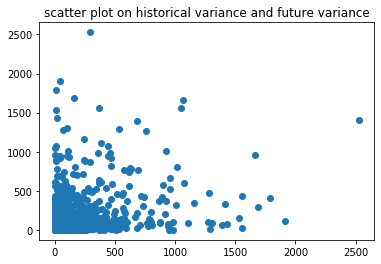

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_3'], Train_df['future_STD_3'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

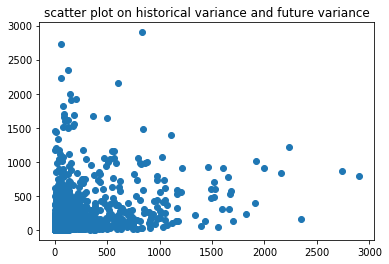

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_5'], Train_df['future_STD_5'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

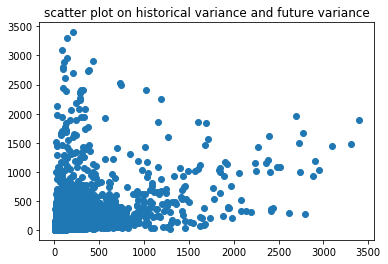

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_10'], Train_df['future_STD_10'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

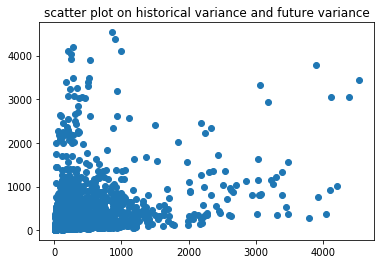

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_14'], Train_df['future_STD_14'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on historical variance and future variance')

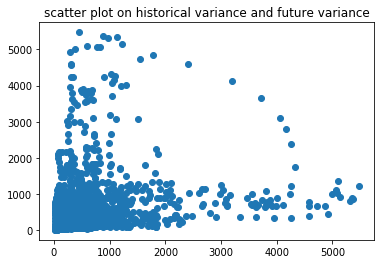

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['STD_20'], Train_df['future_STD_20'])
plt.title('scatter plot on historical variance and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

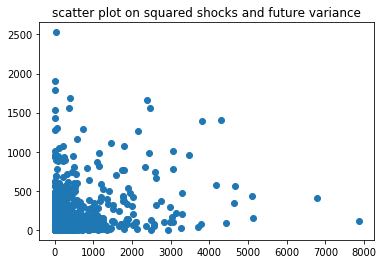

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_3'], Train_df['future_STD_3'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

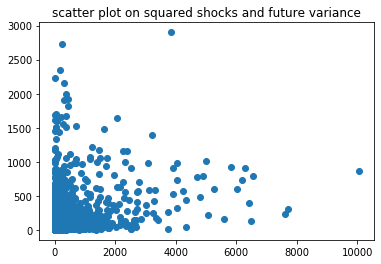

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_5'], Train_df['future_STD_5'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

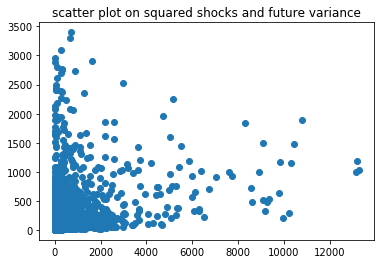

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_10'], Train_df['future_STD_10'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

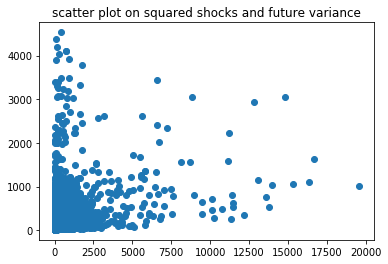

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_14'], Train_df['future_STD_14'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared shocks and future variance')

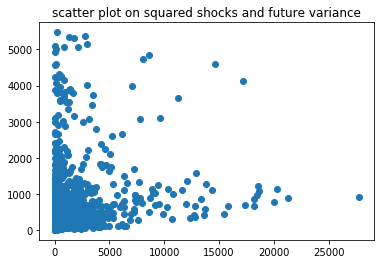

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_sq_20'], Train_df['future_STD_20'])
plt.title('scatter plot on squared shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

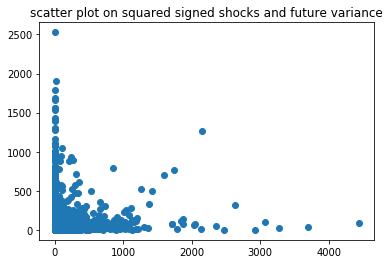

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_3'], Train_df['future_STD_3'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

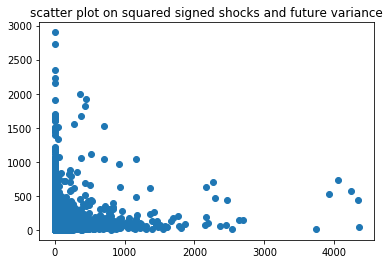

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_5'], Train_df['future_STD_5'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

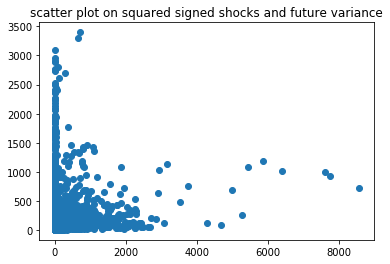

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_10'], Train_df['future_STD_10'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

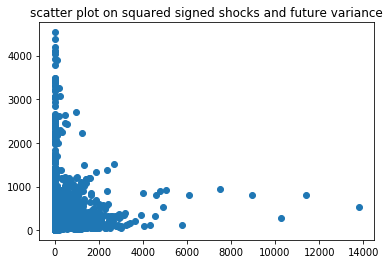

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_14'], Train_df['future_STD_14'])
plt.title('scatter plot on squared signed shocks and future variance')

Text(0.5, 1.0, 'scatter plot on squared signed shocks and future variance')

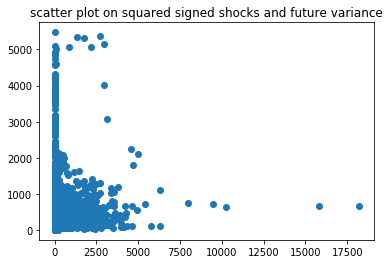

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Train_df['Error_signed_20'], Train_df['future_STD_20'])
plt.title('scatter plot on squared signed shocks and future variance')

([<matplotlib.axis.XTick at 0x27a33ba8dc8>,
 <a list of 5 Text xticklabel objects>)

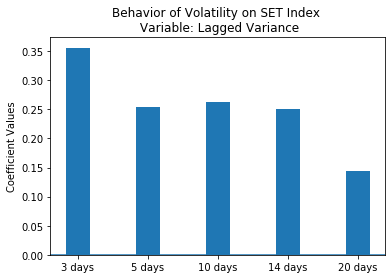

In [16]:
coeff_3 = [ 0.3560598,   0.01316729, -0.10850597]
coeff_5 = [ 0.2548224,   0.0338041,  -0.08503086]
coeff_10 = [ 0.26339204,  0.02086698, -0.06277777]
coeff_14 = [ 0.251338,    0.02982767, -0.0937908 ]
coeff_20 = [ 0.14335229,  0.03485024, -0.0633174 ]

WIDTH = 0.35
IDX = np.arange(5)

fig, ax = plt.subplots()
p1 = ax.bar(IDX, [coeff_3[0], coeff_5[0], coeff_10[0], coeff_14[0], coeff_20[0]], WIDTH)
p2 = ax.axhline(y=0)

plt.ylabel('Coefficient Values')
plt.title('Behavior of Volatility on SET Index \n Variable: Lagged Variance')
plt.xticks(IDX, ('3 days', '5 days', '10 days', '14 days', '20 days'))

([<matplotlib.axis.XTick at 0x27a33b010c8>,
 <a list of 5 Text xticklabel objects>)

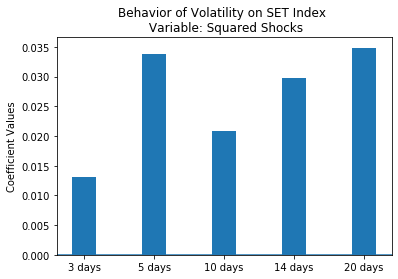

In [17]:
WIDTH = 0.35
IDX = np.arange(5)

fig, ax = plt.subplots()
p1 = ax.bar(IDX, [coeff_3[1], coeff_5[1], coeff_10[1], coeff_14[1], coeff_20[1]], WIDTH)
p2 = ax.axhline(y=0)

plt.ylabel('Coefficient Values')
plt.title('Behavior of Volatility on SET Index \n Variable: Squared Shocks')
plt.xticks(IDX, ('3 days', '5 days', '10 days', '14 days', '20 days'))

([<matplotlib.axis.XTick at 0x27a33afb108>,
 <a list of 5 Text xticklabel objects>)

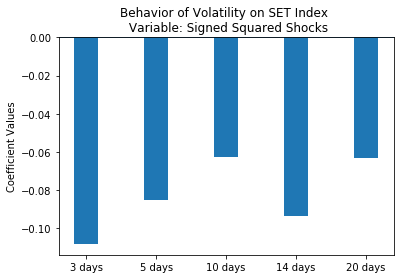

In [18]:
WIDTH = 0.35
IDX = np.arange(5)

fig, ax = plt.subplots()
p1 = ax.bar(IDX, [coeff_3[-1], coeff_5[-1], coeff_10[-1], coeff_14[-1], coeff_20[-1]], WIDTH)
p2 = ax.axhline(y=0)

plt.ylabel('Coefficient Values')
plt.title('Behavior of Volatility on SET Index \n Variable: Signed Squared Shocks')
plt.xticks(IDX, ('3 days', '5 days', '10 days', '14 days', '20 days'))

([<matplotlib.axis.XTick at 0x27a354e0908>,
 <a list of 5 Text xticklabel objects>)

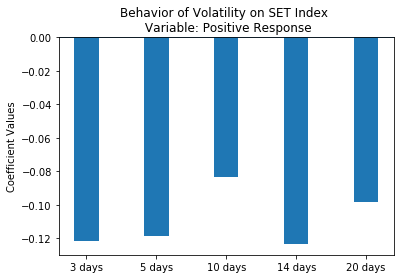

In [23]:
WIDTH = 0.35
IDX = np.arange(5)

fig, ax = plt.subplots()
p1 = ax.bar(IDX, [coeff_3[-1] - coeff_3[1], coeff_5[-1] - coeff_5[1], coeff_10[-1] - coeff_10[1], coeff_14[-1] - coeff_14[1], coeff_20[-1] - coeff_20[1]], WIDTH)
p2 = ax.axhline(y=0)

plt.ylabel('Coefficient Values')
plt.title('Behavior of Volatility on SET Index \n Variable: Positive Response')
plt.xticks(IDX, ('3 days', '5 days', '10 days', '14 days', '20 days'))